In [1]:
import datetime
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
import warnings
import os
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
import pickle
datetime.datetime.now().strftime('%c')

'Fri Jan 10 15:49:42 2025'

# Function # 

In [32]:
def get_rgb_function(cmap, min_value, max_value):
    r"""Generate a function to map continous values to RGB values using colormap between min_value & max_value."""

    if min_value > max_value:
        raise ValueError("Max_value should be greater or than min_value.")

    if min_value == max_value: 
        warnings.warn(
            "Max_color is equal to min_color. It might be because of the data or bad parameter choice. "
            "If you are using plot_contours function try increasing max_color_quantile parameter and"
            "removing cell types with all zero values."
        )

        def func_equal(x):
            factor = 0 if max_value == 0 else 0.5
            return cmap(np.ones_like(x) * factor)

        return func_equal

    def func(x):
        return cmap((np.clip(x, min_value, max_value) - min_value) / (max_value - min_value))

    return func


def rgb_to_ryb(rgb):
    """
    Converts colours from RGB colorspace to RYB

    Parameters
    ----------

    rgb
        numpy array Nx3

    Returns
    -------
    Numpy array Nx3
    """
    rgb = np.array(rgb)
    if len(rgb.shape) == 1:
        rgb = rgb[np.newaxis, :]

    white = rgb.min(axis=1)
    black = (1 - rgb).min(axis=1)
    rgb = rgb - white[:, np.newaxis]

    yellow = rgb[:, :2].min(axis=1)
    ryb = np.zeros_like(rgb)
    ryb[:, 0] = rgb[:, 0] - yellow
    ryb[:, 1] = (yellow + rgb[:, 1]) / 2
    ryb[:, 2] = (rgb[:, 2] + rgb[:, 1] - yellow) / 2

    mask = ~(ryb == 0).all(axis=1)
    if mask.any():
        norm = ryb[mask].max(axis=1) / rgb[mask].max(axis=1)
        ryb[mask] = ryb[mask] / norm[:, np.newaxis]

    return ryb + black[:, np.newaxis]


def ryb_to_rgb(ryb):
    """
    Converts colours from RYB colorspace to RGB

    Parameters
    ----------

    ryb
        numpy array Nx3

    Returns
    -------
    Numpy array Nx3
    """
    ryb = np.array(ryb)
    if len(ryb.shape) == 1:
        ryb = ryb[np.newaxis, :]

    black = ryb.min(axis=1)
    white = (1 - ryb).min(axis=1)
    ryb = ryb - black[:, np.newaxis]

    green = ryb[:, 1:].min(axis=1)
    rgb = np.zeros_like(ryb)
    rgb[:, 0] = ryb[:, 0] + ryb[:, 1] - green
    rgb[:, 1] = green + ryb[:, 1]
    rgb[:, 2] = (ryb[:, 2] - green) * 2

    mask = ~(ryb == 0).all(axis=1)
    if mask.any():
        norm = rgb[mask].max(axis=1) / ryb[mask].max(axis=1)
        rgb[mask] = rgb[mask] / norm[:, np.newaxis]

    return rgb + white[:, np.newaxis]

# add function of gradient custom #  2024 - 1 - 10 # lwm 
def gradient(start_color,end_color,num_steps):
    '''
    Generates a list of gradient colors between two colors
    :parameter 
         start_color : The RGB value of the starting color
         end_color : The RGB value of the ending color
         num_steps : num of gradient colors 
    :return 
        gradient_colors : list of gradient colors
    '''
    r = np.linspace(start_color[0],end_color[0],num_steps)/255
    g = np.linspace(start_color[1],end_color[1],num_steps)/255
    b = np.linspace(start_color[2],end_color[2],num_steps)/255
    # value of RGB to lsit of 
    gradient_colors = np.array([[r[i],g[i],b[i],1]for i in range(num_steps)])
    gradient_colors[:,3] = np.repeat(0.7,num_steps)
    
    return gradient_colors


# plot # 
def plot_spatial_general1(
    value_df,
    coords,
    labels,
    min_intensity = None, # accept number ! 2023-8-31 list 
    max_intensity = None,
    text=None,
    circle_diameter=4.0,
    alpha_scaling=1.0,
    max_col=(np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf),
    max_color_quantile=0.98,
    show_img=True,
    img=None,
    img_alpha=1.0,
    adjust_text=False,
    plt_axis="off",
    axis_y_flipped=True,
    x_y_labels=("", ""),
    crop_x=None,
    crop_y=None,
    text_box_alpha=0.9,
    reorder_cmap=range(7),
    style="fast",
    colorbar_position="bottom",
    colorbar_label_kw={},
    colorbar_shape={},
    colorbar_tick_size=12,
    colorbar_grid=None,
    image_cmap="Greys_r",
    white_spacing=20, # default 20 
): 
    r"""Plot spatial abundance of cell types (regulatory programmes) with colour gradient and interpolation.

      This method supports only 7 cell types with these colours (in order, which can be changed using reorder_cmap).
      'yellow' 'orange' 'blue' 'green' 'purple' 'grey' 'white'

    :param value_df: pd.DataFrame - with cell abundance or other features (only 7 allowed, columns) across locations (rows)
    :param coords: np.ndarray - x and y coordinates (in columns) to be used for ploting spots
    :param text: pd.DataFrame - with x, y coordinates, text to be printed
    :param circle_diameter: diameter of circles
    :param labels: list of strings, labels of cell types
    :param 
    :param alpha_scaling: adjust color alpha
    :param max_col: crops the colorscale maximum value for each column in value_df.
    :param max_color_quantile: crops the colorscale at x quantile of the data.
    :param show_img: show image?
    :param img: numpy array representing a tissue image.
        If not provided a black background image is used.
    :param img_alpha: transparency of the image
    :param lim: x and y max limits on the plot. Minimum is always set to 0, if `lim` is None maximum
        is set to image height and width. If 'no_limit' then no limit is set.
    :param adjust_text: move text label to prevent overlap
    :param plt_axis: show axes?
    :param axis_y_flipped: flip y axis to match coordinates of the plotted image
    :param reorder_cmap: reorder colors to make sure you get the right color for each category

    :param style: plot style (matplolib.style.context):
        'fast' - white background & dark text;
        'dark_background' - black background & white text;

    :param colorbar_position: 'bottom', 'right' or None
    :param colorbar_label_kw: dict that will be forwarded to ax.set_label()
    :param colorbar_shape: dict {'vertical_gaps': 1.5, 'horizontal_gaps': 1.5,
                                    'width': 0.2, 'height': 0.2}, not obligatory to contain all params
    :param colorbar_tick_size: colorbar ticks label size
    :param colorbar_grid: tuple of colorbar grid (rows, columns)
    :param image_cmap: matplotlib colormap for grayscale image
    :param white_spacing: percent of colorbars to be hidden
    :param color_gradient : TURE of FALSE # lwm add 2024 - 1 - 10
    """
    if value_df.shape[1] > 7: # Default 7 : lwm : 9
        raise ValueError("Maximum of 7 cell types / factors can be plotted at the moment")

    def create_colormap(R, G, B):
        spacing = int(white_spacing * 2.55)

        N = 255 
        M = 3

        alphas = np.concatenate([[0] * spacing * M, np.linspace(0, 1.0, (N - spacing) * M)])

        vals = np.ones((N * M, 4))
        #         vals[:, 0] = np.linspace(1, R / 255, N * M)
        #         vals[:, 1] = np.linspace(1, G / 255, N * M)
        #         vals[:, 2] = np.linspace(1, B / 255, N * M)
        for i, color in enumerate([R, G, B]):
            vals[:, i] = color / 255
        vals[:, 3] = alphas

        return ListedColormap(vals)

    
    YellowCM = create_colormap(240, 228, 66)  
    RedCM = create_colormap(213, 94, 0)  
    BlueCM = create_colormap(86, 180, 233)  
    GreenCM = create_colormap(0, 158, 115)  
    GreyCM = create_colormap(200, 200, 200)  
    WhiteCM = create_colormap(50, 50, 50) 
    PurpleCM = create_colormap(90, 20, 165)  
    GreenCM2 = create_colormap(139,251,122) 

    cmaps = [YellowCM, RedCM, BlueCM, GreenCM, PurpleCM,GreyCM, WhiteCM, GreenCM2]

    cmaps = [cmaps[i] for i in reorder_cmap]
    
    with mpl.style.context(style):
        fig = plt.figure()

        if colorbar_position == "right":
            if colorbar_grid is None:
                colorbar_grid = (len(labels), 1)

            shape = {"vertical_gaps": 1.5, "horizontal_gaps": 0, "width": 0.15, "height": 0.2}
            shape = {**shape, **colorbar_shape}

            gs = GridSpec(
                nrows=colorbar_grid[0] + 2,
                ncols=colorbar_grid[1] + 1,
                width_ratios=[1, *[shape["width"]] * colorbar_grid[1]],
                height_ratios=[1, *[shape["height"]] * colorbar_grid[0], 1],
                hspace=shape["vertical_gaps"],
                wspace=shape["horizontal_gaps"],
            )
            ax = fig.add_subplot(gs[:, 0], aspect="equal", rasterized=True)

        if colorbar_position == "bottom":
            if colorbar_grid is None:
                if len(labels) <= 3:
                    colorbar_grid = (1, len(labels))
                else:
                    n_rows = round(len(labels) / 3 + 0.5 - 1e-9)
                    colorbar_grid = (n_rows, 3)

            shape = {"vertical_gaps": 0.3, "horizontal_gaps": 0.6, "width": 0.2, "height": 0.035}
            shape = {**shape, **colorbar_shape}

            gs = GridSpec(
                nrows=colorbar_grid[0] + 1,
                ncols=colorbar_grid[1] + 2,
                width_ratios=[0.3, *[shape["width"]] * colorbar_grid[1], 0.3],
                height_ratios=[1, *[shape["height"]] * colorbar_grid[0]],
                hspace=shape["vertical_gaps"],
                wspace=shape["horizontal_gaps"],
            )

            ax = fig.add_subplot(gs[0, :], aspect="equal", rasterized=True)

        if colorbar_position is None:
            ax = fig.add_subplot(aspect="equal", rasterized=True)

        if colorbar_position is not None:
            cbar_axes = []
            for row in range(1, colorbar_grid[0] + 1):
                for column in range(1, colorbar_grid[1] + 1):
                    cbar_axes.append(fig.add_subplot(gs[row, column]))

            n_excess = colorbar_grid[0] * colorbar_grid[1] - len(labels)
            if n_excess > 0:
                for i in range(1, n_excess + 1):
                    cbar_axes[-i].set_visible(False)

        ax.set_xlabel(x_y_labels[0])
        ax.set_ylabel(x_y_labels[1])

        if img is not None and show_img:
            ax.imshow(img, aspect="equal", alpha=img_alpha, origin="lower", cmap=image_cmap)

        # crop images in needed
        if crop_x is not None:
            ax.set_xlim(crop_x[0], crop_x[1])
        if crop_y is not None:
            ax.set_ylim(crop_y[0], crop_y[1])

        if axis_y_flipped:
            ax.invert_yaxis()

        if plt_axis == "off":
            for spine in ax.spines.values():
                spine.set_visible(False)
            ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

        counts = value_df.values.copy() 

        # plot spots as circles
        c_ord = list(np.arange(0, counts.shape[1]))

        colors = np.zeros((*counts.shape, 4))
        weights = np.zeros(counts.shape)
        
        for c in c_ord:
            print("c: ",c) # lwm
            if isinstance(min_intensity, list):
                min_int = min_intensity[c]
            else :
                min_int = min_intensity
                
            if isinstance(max_intensity, list):
                max_int = max_intensity[c]
            else :
                max_int = max_intensity
            
            if min_int is not None:
                min_color_intensity = min_intensity[c] # lwm 2024 - 2 - 23
            else:
                print(c,"min color intesity is None ! ")
                min_color_intensity = counts[:, c].min()  
            if max_int is not None: 
                max_color_intensity = max_intensity[c] # lwm 2024 - 2 - 23
            else:
                print(c,"max color intensity is None ! ") 
                max_color_intensity = np.min([np.quantile(counts[:, c], max_color_quantile), max_col[c]]) 
            print("min_color_intensity : ",min_color_intensity)
            print("max_color_intensity : ",max_color_intensity)
            
            rgb_function = get_rgb_function(cmap=cmaps[c], min_value=min_color_intensity, max_value=max_color_intensity)
           
            color = rgb_function(counts[:, c])
            color[:, 3] = color[:, 3] * alpha_scaling
            
           
            norm = mpl.colors.Normalize(vmin=min_color_intensity, vmax=max_color_intensity) 
   
                
            if colorbar_position is not None:
                cbar_ticks = [
                    min_color_intensity,
                    np.mean([min_color_intensity, max_color_intensity]),
                    max_color_intensity,
                ]
                cbar_ticks = np.array(cbar_ticks)

                if max_color_intensity > 13:
                    cbar_ticks = cbar_ticks.astype(np.int32)
                else:
                    cbar_ticks = cbar_ticks.round(2)
 
                cbar = fig.colorbar(
                    mpl.cm.ScalarMappable(norm=norm, cmap= cmaps[c]), 
                    cax=cbar_axes[c],
                    orientation="horizontal",
                    extend="both",
                    ticks=cbar_ticks,
                ) 

                cbar.ax.tick_params(labelsize=colorbar_tick_size)
                max_color = rgb_function(max_color_intensity / 1.5)
                cbar.ax.set_title(labels[c], **{**{"size": 20, "color": max_color, "alpha": 1}, **colorbar_label_kw})

            colors[:, c] = color
            weights[:, c] = np.clip(counts[:, c] / (max_color_intensity + 1e-10), 0, 1)
            weights[:, c][counts[:, c] < min_color_intensity] = 0

        colors_ryb = np.zeros((*weights.shape, 3))

        for i in range(colors.shape[0]):
            colors_ryb[i] = rgb_to_ryb(colors[i, :, :3])

        def kernel(w):
            return w**2
        
        # gene expression color spot # lwm
        kernel_weights = kernel(weights[:, :, np.newaxis])
        
        # warning # RuntimeWarning: invalid value encountered in true_divide # lwm
        weighted_colors_ryb = (colors_ryb * kernel_weights).sum(axis=1) / kernel_weights.sum(axis=1)

        weighted_colors = np.zeros((weights.shape[0], 4))

        weighted_colors[:, :3] = ryb_to_rgb(weighted_colors_ryb)

        weighted_colors[:, 3] = colors[:, :, 3].max(axis=1)
        
        ax.scatter(x=coords[:, 0], y=coords[:, 1], c=weighted_colors, s=circle_diameter**2)
        
        # add text
        if text is not None:
            bbox_props = dict(boxstyle="round", ec="0.5", alpha=text_box_alpha, fc="w")
            texts = []
            for x, y, s in zip(
                np.array(text.iloc[:, 0].values).flatten(),
                np.array(text.iloc[:, 1].values).flatten(),
                text.iloc[:, 2].tolist(),
            ):
                texts.append(ax.text(x, y, s, ha="center", va="bottom", bbox=bbox_props))

            if adjust_text:
                from adjustText import adjust_text

                adjust_text(texts, arrowprops=dict(arrowstyle="->", color="w", lw=0.5))

    return fig,ax
datetime.datetime.now().strftime('%c')

'Fri Jan 10 16:01:13 2025'

In [3]:
def add_ScaleRuler(fig,x,y,length,size,label,lw,local,background):
    r'''
    :para fig: main plot 
    :para x: x axis position of scale ruler
    :para y: y axis position of scale ruler 
    :para length: length of scale ruler
    :para size:  y axis high of scale ruler
    :para label: unit of scale ruler ,Default : "10μm" 
    :para lw: line width,Default : 2
    '''
    if background == "dark_background":
        color = 'white'
    elif background == "fast":
        color = 'black'
    ax = fig.get_axes()
    
    ax[0].hlines(y= y,  xmin = x, xmax = x+length, colors="yellow", ls="-", lw=lw)

    return(fig)

In [4]:
def CreateParaDict(Filelist,Samplelist,Genelist,NoneGenelist,AllGene,
                   Celltypes,SpotSize,Colorlist,Output):
    r'''
    :parameter Filelist : list
    :parameter Samplelist : list
    :parameter NoneGenelist : list
    :parameter Genelist : list 
    :parameter AllGene : list
    :parameter Celltypes : list
    :parameter SpotSize : list
    :parameter Colorlist: list 
    :parameter Output : str
    ...
    '''
    ParaDict = {'filelist' : Filelist,
                'samplelist': Samplelist,
                'NoneGenelist': NoneGenelist,
                'Genelist': Genelist,
                'AllGene': AllGene, 
                'Celltypes': Celltypes,
                'SpotSize': SpotSize,
                'Colorlist': Colorlist,
                'Output': Output}
    return(ParaDict)
datetime.datetime.now().strftime('%c')

'Fri Jan 10 15:49:50 2025'

In [29]:
def MutilGeneExperssion(ParaDict,min_intensity,max_intensity,Figsize = (8,4),
                        Style = 'dark_background',ColorBarSize = 6,ColorbarTickSize = 6,size=60,
                        ruler_length = 400,label = "200 μm",lw = 4,x_shift = 500,
                        y_local = 600,method = "single"):
    r'''
    :parameter ParaDict : dict
    :parameter min_intensity : 
    :parameter max_intensity : 
    :parameter Figsize : tuple
    :parameter CircleDiameter : number 
    :parameter ColorBarSize : number
    :parameter Style : plot style (matplolib.style.context):
                          'fast' - white background & dark text;
                          'dark_background' - black background & white text;
    :parameter ColorbarTickSize : 
    :parameter size : 
    :parameter ruler.length : 
    :parameter label : 
    :parameter lw : 
    :parameter x.shift :
    :parameter y.local : 
    :parameter method : 
    '''
    # plt.rcParams['savefig.transparent'] = True # zhangzhao 2023 - 11 - 10
    # parameter #
    filelist = ParaDict['filelist']
    samplelist = ParaDict['samplelist']
    NoneGenelist = ParaDict['NoneGenelist']
    Genelist = ParaDict['Genelist']
    AllGene = ParaDict['AllGene']
    Celltypes = ParaDict['Celltypes']
    Colorlist = ParaDict['Colorlist']
    SpotSize = ParaDict['SpotSize']
    Output = ParaDict['Output']
    
    for i in range(0,len(samplelist)):
        file = filelist[i]
        sample = samplelist[i]
        print("sample: ",sample) # sample
        out = output + "/" + sample
        print(out)
        if(os.path.exists(out)):
            print("Project Exist!")
        else :
            os.mkdir(out) # out project
        
        # input #
        adata = sc.read_h5ad(file)
        sc.pp.normalize_total(adata, target_sum=1e4) # normalize #
        sc.pp.log1p(adata) # log1p #
   
        adata.var.index = adata.var['features']
        GeneExp  = adata.to_df().copy()
        
        # change y axis #
        adata.obs[['y']] = - adata.obs[["y"]] # notice # 
        adata.obsm['spatial'] = adata.obs[["x","y"]].values
        coord = adata.obsm["spatial"]
        
        # Get All Experssion Gene #
        NoneGene = NoneGenelist[i] # NoneGene 
        gene = list(set(AllGene).difference(NoneGene)) # All Experssion Gene 
        gene2 = pd.DataFrame(gene).drop_duplicates()[0].to_list() # duplicate #
        
        # Gene Experssion data.frame #
        GeneExp = GeneExp[gene2]
        
        # celltypes #
        # genelist #
        
        if method == "single": # score or single gene expression   
            print("single")
            for j in range(0,len(Genelist)):
                print(j)
                ct = Celltypes[j] # each celltypes 
                gene3 = Genelist[j]
                genel = list(set(gene3).difference(NoneGene)) # Get each celltypes Experssion Gene 
                CircleDiameter = SpotSize[j]
                color = Colorlist[j]
                if len(genel) > 1 : # cal gene exp score 
                    print("genel: ",genel)
                    score_str = ct + "_score"
                    sc.tl.score_genes(adata,gene_list = genel,
                                    score_name = score_str,use_raw = False) # warnning # 
                    marker = [score_str]
                    GeneExp2 = adata.obs[score_str].to_frame() # only one gene list score
                    
                else :
                    marker = genel
                    GeneExp2 = GeneExp[genel]
                    
                
                plt.rcParams["figure.figsize"] = Figsize # 
                fig, ax = plot_spatial_general1(value_df=GeneExp2, coords=adata.obsm["spatial"],
                                min_intensity = min_intensity,
                                max_intensity = max_intensity,
                                labels=marker, circle_diameter= CircleDiameter, 
                                style = Style, reorder_cmap = color,
                                colorbar_position="right", 
                                colorbar_tick_size=ColorbarTickSize, 
                                colorbar_label_kw={"size":ColorBarSize}, max_color_quantile=1, img_alpha=1) # 1
                ax.scatter(coord[:,0], coord[:,1], color="#E0E0E0", marker=".", zorder=0, s=0.1)
                fig = add_ScaleRuler(fig = fig,x=adata.obs["x"].max() + x_shift,y=adata.obs["y"].max(),
                                      length = ruler_length,size=size,label=label,lw=lw,background = Style,
                                      local = y_local)
                
        elif method == 'multiple': # multiple Gene Expression # single gene expression  
            print("multiple")
            ct = Celltypes
            CircleDiameter = SpotSize
            color = Colorlist
            genel = list(set(Genelist).difference(NoneGene))
            marker = genel
            GeneExp2 = GeneExp[genel]

            plt.rcParams["figure.figsize"] = Figsize # 
            
            fig, ax = plot_spatial_general1(value_df=GeneExp2, coords=adata.obsm["spatial"], 
                                min_intensity = min_intensity,
                                max_intensity = max_intensity,
                                labels=marker, circle_diameter= CircleDiameter, 
                                style = Style, reorder_cmap = color,
                                colorbar_position="right", 
                                colorbar_tick_size=ColorbarTickSize,  
                                colorbar_label_kw={"size":ColorBarSize}, max_color_quantile=1, img_alpha=1) 
            ax.scatter(coord[:,0], coord[:,1], color="#E0E0E0", marker=".", zorder=0, s=0.1)

            fig = add_ScaleRuler(fig = fig,x=adata.obs["x"].max() + x_shift ,y=adata.obs["y"].max(),
                                      length = ruler_length,size = size,label=label,background = Style,
                                      lw=lw,local = y_local)
            
            
        else : 
            print("Please check your method!") 
        
        output_fig = out + '/' + sample + "_" + ct + "_gene.pdf"
        print(output_fig)
        fig.savefig(output_fig,dpi = 512)
        print("--- end ----")
        return(fig)
datetime.datetime.now().strftime('%c')   

'Fri Jan 10 16:00:29 2025'

# tissue 

## ileum 

### single gene expression 

In [41]:
genelist = ['Apoa1']
Allgene = ['Apoa1']
Celltypes = 'Apoa1'
NoneGenelist =[[]]
Colorlist = [0] 
SpotSize = 1
min_intensity = [0]
max_intensity = [7.5]

#### GF_ileum1

In [43]:
filelist  = ['/data/work/03_Spatialh5ad/check/new/GF_ileum1_bin20.h5ad']
output = "/data/work/08_plot"
samplelist = ["GF_ileum1"] 
Dict = CreateParaDict(Filelist = filelist, Samplelist = samplelist,
                      NoneGenelist = NoneGenelist,Genelist = genelist, 
                      AllGene = Allgene,Celltypes = Celltypes,
                      SpotSize = SpotSize,Colorlist = Colorlist,
                      Output=output)

fig = MutilGeneExperssion(Dict,min_intensity = min_intensity ,max_intensity = max_intensity,
                    Style = 'dark_background',ColorBarSize = 8,ColorbarTickSize = 10,size = 80,
                    ruler_length = 400,label = "200 μm",lw = 2,y_local  = 200,x_shift = 0,
                    method = "multiple")
datetime.datetime.now().strftime('%c')

sample:  GF_ileum1
/data/work/08_plot/GF_ileum1
Project Exist!
multiple
c:  0
min_color_intensity :  0
max_color_intensity :  7.5


/tmp/ipykernel_361/2789749317.py:383: RuntimeWarning: invalid value encountered in true_divide
  weighted_colors_ryb = (colors_ryb * kernel_weights).sum(axis=1) / kernel_weights.sum(axis=1)


/data/work/08_plot/GF_ileum1/GF_ileum1_Apoa1_gene.pdf
--- end ----


'Fri Jan 10 16:03:30 2025'

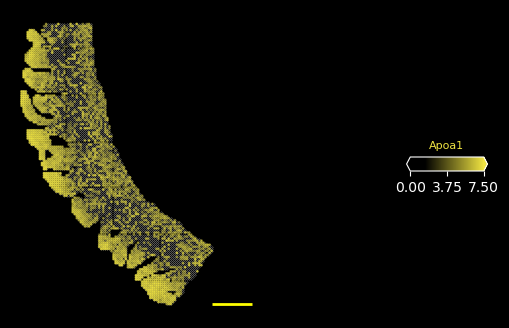

In [44]:
fig

### single genelist score

In [45]:
genelist = [['Jchain','Ighg3','Ighg2b','Ighg2c','Ighg1','Igha']]
Allgene = ['Jchain','Ighg3','Ighg2b','Ighg2c','Ighg1','Igha']
Celltypes = ['Plasma']
SpotSize = [1]  
Colorlist = [[0]]
min_intensity = [-0.6]
max_intensity = [4.3]

In [46]:
filelist  = ['/data/work/03_Spatialh5ad/check/new/GF_ileum1_bin20.h5ad']
output = "/data/work/08_plot/"
samplelist = ["GF_ileum1"] 
NoneGenelist =[['Ighg2c']] # "['Ighg2c'] not in index" Plasma 
Dict = CreateParaDict(Filelist = filelist, Samplelist = samplelist,
                      NoneGenelist = NoneGenelist,Genelist = genelist, 
                      AllGene = Allgene,Celltypes = Celltypes,
                      SpotSize = SpotSize,Colorlist = Colorlist,
                      Output=output)

fig = MutilGeneExperssion(Dict,min_intensity = min_intensity ,max_intensity = max_intensity,
                    # min_intensity = None ,max_intensity = None,
                    Style = 'dark_background',ColorBarSize = 8,ColorbarTickSize = 10,size = 80,
                    ruler_length = 400,label = "200 μm",lw = 2,y_local  = 200,x_shift = 0,
                    method = "single")
datetime.datetime.now().strftime('%c')

sample:  GF_ileum1
/data/work/08_plot//GF_ileum1
Project Exist!
single
0
genel:  ['Jchain', 'Igha', 'Ighg3', 'Ighg1', 'Ighg2b']
c:  0
min_color_intensity :  -0.6
max_color_intensity :  4.3


/opt/conda/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/tmp/ipykernel_361/2789749317.py:383: RuntimeWarning: invalid value encountered in true_divide
  weighted_colors_ryb = (colors_ryb * kernel_weights).sum(axis=1) / kernel_weights.sum(axis=1)


/data/work/08_plot//GF_ileum1/GF_ileum1_Plasma_gene.pdf
--- end ----


'Fri Jan 10 16:03:50 2025'

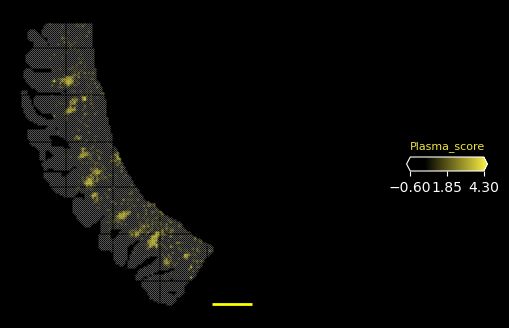

In [47]:
fig

### multiple gene exprssion 

### ileum 

In [48]:
genelist = ['Ighg3','Ighg2b','Ighg2c','Ighg1','Igha']
Allgene = ['Ighg3','Ighg2b','Ighg2c','Ighg1','Igha']
Celltypes = 'Plasma2'
SpotSize = 1

#### GF ileum1 

In [49]:
filelist  = ['/data/work/03_Spatialh5ad/check/new/GF_ileum1_bin20.h5ad']
output = "/data/work/08_plot"
samplelist = ["GF_ileum1"] 
NoneGenelist = [['Ighg2c']] # KeyError: "['Ighg2c'] not in index" 
Colorlist =[1,2,2,2] # ['Igha', 'Ighg3', 'Ighg1', 'Ighg2b']
min_intensity = [0,0,0,0]
max_intensity = [7.9,3.6,3.9,5.3]
Dict = CreateParaDict(Filelist = filelist, Samplelist = samplelist,
                      NoneGenelist = NoneGenelist,Genelist = genelist, 
                      AllGene = Allgene,Celltypes = Celltypes,
                      SpotSize = SpotSize,Colorlist = Colorlist,
                      Output=output)

fig = MutilGeneExperssion(Dict,min_intensity = min_intensity ,max_intensity = max_intensity,
                    Style = 'dark_background',ColorBarSize = 8,ColorbarTickSize = 10,size = 80,
                    ruler_length = 400,label = "200 μm",lw = 2,y_local  = 200,x_shift = 0,
                    method = "multiple")
datetime.datetime.now().strftime('%c')

sample:  GF_ileum1
/data/work/08_plot/GF_ileum1
Project Exist!
multiple
c:  0
min_color_intensity :  0
max_color_intensity :  7.9
c:  1
min_color_intensity :  0
max_color_intensity :  3.6
c:  2
min_color_intensity :  0
max_color_intensity :  3.9
c:  3
min_color_intensity :  0
max_color_intensity :  5.3


/tmp/ipykernel_361/2789749317.py:383: RuntimeWarning: invalid value encountered in true_divide
  weighted_colors_ryb = (colors_ryb * kernel_weights).sum(axis=1) / kernel_weights.sum(axis=1)


/data/work/08_plot/GF_ileum1/GF_ileum1_Plasma2_gene.pdf
--- end ----


'Fri Jan 10 16:04:04 2025'

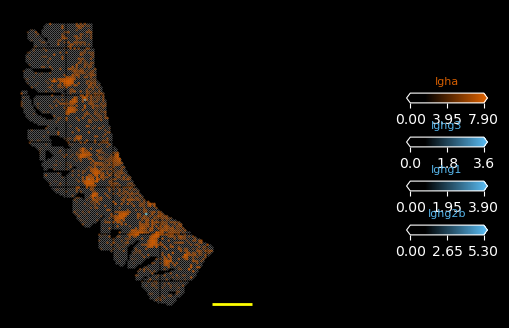

In [50]:
fig